In [1]:
import uproot
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from collections import namedtuple, defaultdict
import open3d as o3d
import random
random.seed(42)
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib

In [2]:
hf_true_neighbor_indices= h5py.File("./true_neighbor_200k.hdf5", 'r')

In [3]:
true_neighbor = hf_true_neighbor_indices.get('true_neighbor')[:]

In [4]:
hf_true_neighbor_indices.close()

In [6]:
len(true_neighbor)

200000

## Opening files containing features in pairs of cells from same cluster (+ve e.g.) and different cluster (-ve e.g)

In [2]:
hf_pair_indices= h5py.File("./true_pair_index.hdf5", 'r')
hf_nopair_indices = h5py.File("./false_pair_index.hdf5", 'r')
hf_cellFeatures = h5py.File("./cellFeatures.hdf5", 'r')
hf_sharedCellsIndices = h5py.File("./sharedCellsIndices.hdf5", 'r')
hf_cellFeatures_ev1 = h5py.File("./cellFeatures.hdf5", 'r')
hf_sharedCellsIndices_ev1 = h5py.File("./sharedCellsIndices.hdf5", 'r')

In [3]:
true_pair = hf_pair_indices.get('true_pair')[:]
false_pair = hf_nopair_indices.get('false_pair')[:]
cellFeatures = hf_cellFeatures.get('cellFeatures')[:]
sharedCells = hf_sharedCellsIndices.get('sharedCellsIndices')[:]
cellFeatures_ev1 = hf_cellFeatures_ev1.get('cellFeatures')[:]
sharedCells_ev1 = hf_sharedCellsIndices_ev1.get('sharedCellsIndices')[:]

In [4]:
hf_pair_indices.close()
hf_nopair_indices.close()
hf_cellFeatures.close()
hf_sharedCellsIndices.close()
hf_cellFeatures_ev1.close()
hf_sharedCellsIndices_ev1.close()

In [6]:
print("true_pair.shape: ",true_pair.shape)
print("false_pair.shape: ",false_pair.shape)
print("cellFeatures.shape: ",cellFeatures.shape)
print("sharedCells.shape: ",sharedCells.shape)
print("cellFeatures_ev1.shape: ",cellFeatures.shape)
print("sharedCells_ev1.shape: ",sharedCells.shape)

true_pair.shape:  (673264, 2)
false_pair.shape:  (511897, 2)
cellFeatures.shape:  (187652, 8)
sharedCells.shape:  (757,)
cellFeatures_ev1.shape:  (187652, 8)
sharedCells_ev1.shape:  (757,)


In [8]:
false_pair_500k = false_pair[:500000] # using 500k nopais
true_pair_500k = true_pair[:500000]          # using 500k pais

In [10]:
print("pair_500k.shape: ",true_pair_500k.shape)
print("nopair_500k.shape: ",false_pair_500k.shape)

pair_500k.shape:  (500000, 2)
nopair_500k.shape:  (500000, 2)


## Concatenating +ve and -ve examples

In [12]:
total_indices = np.concatenate((true_pair_500k,false_pair_500k),axis=0)

In [13]:
total_indices.shape

(1000000, 2)

## Making labels 1 for +ve e.g and -1 for -ve e.g

In [16]:
total_label = np.concatenate(([1]*500000,[-1]*500000),axis=0)

In [17]:
total_label.shape

(1000000,)

In [18]:
total_label

array([ 1,  1,  1, ..., -1, -1, -1])

## Randomizing data and dividing into train, test parts

In [20]:
arr = np.arange(1000000)
np.random.shuffle(arr)

In [21]:
total_indices_rand = total_indices[arr]
total_label_rand =  total_label[arr]

In [22]:
total_indices_train, total_indices_test, truth_label_train, truth_label_test = train_test_split(
    total_indices_rand, total_label_rand, train_size=0.70)

In [23]:
total_indices_train.shape

(700000, 2)

In [24]:
total_indices_test.shape

(300000, 2)

In [25]:
# creating pair and no pair indices file
with h5py.File('./test_pair.hdf5', 'w') as f: 
    dset = f.create_dataset("test_pair", data = total_indices_test)

with h5py.File('./test_truth.hdf5', 'w') as f: 
    dset = f.create_dataset("test_truth_label", data = truth_label_test)

### Based on the train-test cell indices find the cell features and scale them

In [26]:
# find the unique cell indices in the pair
train_index_set = set()
for item in total_indices_train:
    if item[0] not in train_index_set:
        train_index_set.add(item[0])
    elif item[1] not in train_index_set:
        train_index_set.add(item[1])


In [27]:
len(train_index_set)

130893

In [28]:
# find the unique cell indices in the pair
test_index_set = set()
for item in total_indices_test:
    if item[0] not in test_index_set:
        test_index_set.add(item[0])
    elif item[1] not in test_index_set:
        test_index_set.add(item[1])

In [29]:
len(test_index_set)

71844

## MinMax Scaling training set

In [30]:
train_index_list = list(train_index_set)
test_index_list = list(test_index_set)

In [31]:
with h5py.File('./test_index_list.hdf5', 'w') as f: 
    dset = f.create_dataset("test_index_list", data = test_index_list)

In [32]:
for item in test_index_list:
    if item in train_index_list:
        index = test_index_list.index(item)
        test_index_list.pop(index)

In [33]:
len(test_index_list)

55429

In [34]:
cellFeatures_train = cellFeatures[train_index_list]
cellFeatures_test = cellFeatures[test_index_list]

In [36]:
scaler = MinMaxScaler()
cellFeatures_trainS = scaler.fit_transform(cellFeatures_train)
scaler_filename = "./scaler.save"
joblib.dump(scaler, scaler_filename)
#cellFeatures_testS = scaler.transform(cellFeatures_test)
#cellFeatures_testS_ev1 = scaler.transform(cellFeatures_ev1)

['./scaler.save']

In [37]:
scaler = joblib.load('./scaler.save') 

In [38]:
cellFeatures_testS = scaler.transform(cellFeatures_test)

In [39]:
cellFeatures.shape

(187652, 8)

### Insert cellFeatures_train/test in a cellFeaturesScaled array 

In [40]:
cellFeaturesScaled =np.zeros((187652, 8))
cell = 0
for i in train_index_list:
    cellFeaturesScaled[i] = cellFeatures_trainS[cell]
    cell = cell+1

In [41]:
cell = 0
for i in test_index_list:
    cellFeaturesScaled[i] = cellFeatures_testS[cell]
    cell = cell+1

In [42]:
# creating Scaled Cell Feature file
with h5py.File('./cellFeaturesScaled.hdf5', 'w') as f: 
    dset = f.create_dataset("cellFeaturesScaled", data = cellFeaturesScaled)
    
with h5py.File('./cellFeaturesScaled_ev1.hdf5', 'w') as f: 
    dset = f.create_dataset("cellFeaturesScaled", data = cellFeatures_testS_ev1)

NameError: name 'cellFeatures_testS_ev1' is not defined

## Preparing pairwise features

In [43]:
# Train feature pairs
pair_features_train =[]
for pair in total_indices_train:
    pair_features_train.append((cellFeaturesScaled[pair[0]],\
                          cellFeaturesScaled[pair[1]]))

In [44]:
pair_features_train[0]

(array([7.05564724e-01, 4.69600971e-01, 2.61258294e-01, 3.46799460e-01,
        4.76682711e-01, 4.34782609e-02, 1.99983229e-04, 1.65355553e-01]),
 array([7.07529058e-01, 4.90033260e-01, 2.66297121e-01, 3.48760830e-01,
        4.92344469e-01, 4.34782609e-02, 1.83149582e-04, 1.65607871e-01]))

In [45]:
# Convert data to PyTorch tensors
pairs = [(torch.Tensor(pair[0]), torch.Tensor(pair[1])) for pair in pair_features_train]
labels = torch.tensor(truth_label_train, dtype=torch.float32)

In [47]:
# Test feature pairs
pair_features_test =[]
for pair in total_indices_test:
    pair_features_test.append((cellFeaturesScaled[pair[0]],\
                          cellFeaturesScaled[pair[1]]))

In [48]:
# Convert data to PyTorch tensors
testPairs = [(torch.Tensor(pair[0]), torch.Tensor(pair[1])) for pair in pair_features_test]
testLabels = torch.tensor(truth_label_test, dtype=torch.float32)

### Making Pytorch specific dataset and Network and Loss

In [50]:
# Custom dataset for pairwise training
class SiameseDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        pair = (self.data[index][0], self.data[index][1])
        label = torch.tensor(self.labels[index], dtype=torch.float32)

        if self.transform:
            pair = (self.transform(pair[0]), self.transform(pair[1]))

        return pair, label


In [51]:
# taking fewer training sample to resolve exploding network weight
pairs_50k = pairs[:]
labels_50k = labels[:]

In [81]:
#pairs_50k

In [81]:
class SiameseNetwork(nn.Module):
    def __init__(self, input_size):
        super(SiameseNetwork, self).__init__()

        # Define the architecture for one branch of the Siamese network
        self.branch = nn.Sequential(
            nn.Linear(input_size, 128),
            #nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 128),
            #nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 128),
            #nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            #nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 32),
            #nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 16),
        )

    def forward_one(self, x):
        # Forward pass for one branch of the Siamese network
        return self.branch(x)

    def forward(self, input1, input2):
        # Forward pass for both branches of the Siamese network
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2

In [82]:
input_size = 8# Adjust this based on your input data size
#hidden_size = 32  # You can customize this based on your task

# Create a Siamese network
siamese_net = SiameseNetwork(input_size)

# Create a pairwise hinge loss criterion
#criterion = PairwiseHingeLoss()

# Set up data loaders
#transform = transforms.Compose([transforms.ToTensor()])
#dataset = SiameseDataset(data=pairs, labels=labels, transform=transform)
dataset = SiameseDataset(data=pairs_50k, labels=labels_50k)
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True)

testDataset = SiameseDataset(data=testPairs, labels=testLabels)
testDataloader = DataLoader(testDataset, batch_size=300000, shuffle=False)

#ev1Dataset = SiameseDataset(data=ev1Pairs, labels=ev1Labels)
#ev1Dataloader = DataLoader(ev1Dataset, batch_size=950580, shuffle=False)

## Analysis of test Data before training in 8D space

In [83]:
# Distance of test sample before training
testDist = []
testLabel = []
for batch in testDataloader:
        inputs, target = batch
        input1, input2 = inputs

        # Forward pass
        #output1, output2 = siamese_net(input1, input2)
        distances = torch.pairwise_distance(input1, input2)
        testDist.append(distances)
        testLabel.append(target)

/var/folders/k8/cklb1sxj1p35mft4gbkymsc091k_dc/T/ipykernel_94884/98518432.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(self.labels[index], dtype=torch.float32)


In [84]:
distArray_b4 = testDist[0].detach().numpy()
labelArray_b4 = testLabel[0].detach().numpy()

In [85]:
simCells_b4 = [i for i in range(len(labelArray_b4)) if labelArray_b4[i]==1]
asimCells_b4 = [i for i in range(len(labelArray_b4)) if labelArray_b4[i]==-1]
simArray_b4 = distArray_b4[simCells_b4]
asimArray_b4 = distArray_b4[asimCells_b4]

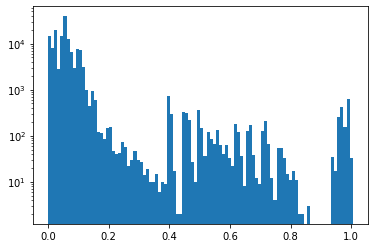

In [86]:
plt.hist(simArray_b4, bins = 100)
plt.yscale("log")
#plt.xlim(0,0.1)
plt.show()

In [87]:
max(simArray_b4)

1.0048507

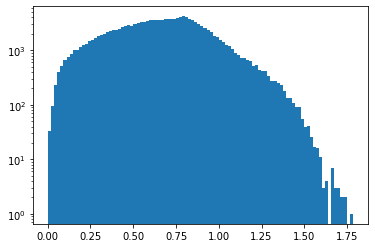

In [88]:
plt.hist(asimArray_b4, bins=100)
plt.yscale("log")
#plt.xlim(0,0.1)
plt.show()

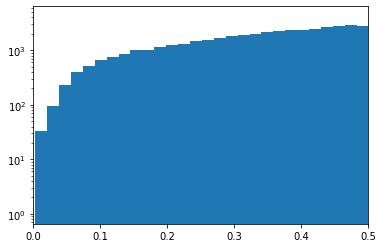

In [89]:
plt.hist(asimArray_b4, bins=100)
plt.yscale("log")
plt.xlim(0,0.5)
plt.show()

In [95]:
len(total_indices_test)

300000

In [96]:
len(testLabel[0])

300000

In [97]:
nopairIndex = total_indices_test[asimCells_b4]
len(nopairIndex)

150505

In [98]:
len(asimArray_b4)

150505

In [99]:
asym_sort_index_b4 = sorted(range(len(asimArray_b4)), key=lambda k: asimArray_b4[k])

In [100]:
sym_sort_index_b4 = sorted(range(len(simArray_b4)), key=lambda k: simArray_b4[k])

In [101]:
asimArray_b4_sorted = asimArray_b4[asym_sort_index_b4]
simArray_b4_sorted = simArray_b4[sym_sort_index_b4]
nopairIndex_sorted = nopairIndex[asym_sort_index_b4]

In [102]:
asimArray_b4_sorted_100 = asimArray_b4_sorted[:100]

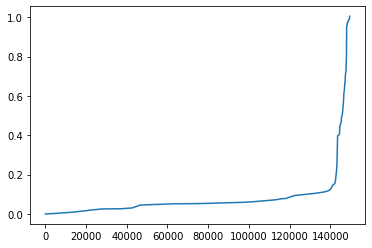

In [103]:
plt.plot(simArray_b4_sorted)
#plt.yscale("log")
#plt.xlim(0,0.5)
plt.show()

In [104]:
print(siamese_net)

SiameseNetwork(
  (branch): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): ReLU(inplace=True)
    (10): Linear(in_features=32, out_features=16, bias=True)
  )
)


In [105]:
len(dataloader)

684

In [76]:
#dataset.data

In [106]:
# Set up optimizer
optimizer = optim.Adam(siamese_net.parameters(), lr=0.001)

In [107]:
# Accuracy calculation function
def calculate_accuracy(output1, output2, target, threshold=1):
    distances = nn.functional.pairwise_distance(output1, output2)
    #print("distances: ",distances)
    predictions = (distances < threshold).float()
    #print("predictions: ",predictions)
    #print("target: ",target)
    correct_predictions = (predictions == target).float()
    #print("correct_predictions: ",correct_predictions)
    accuracy = correct_predictions.mean().item()
    #print("accuracy: ",accuracy)
    return accuracy

In [108]:
# Margin for hinge loss
margin = 1

# Define the Hinge Embedding Loss
hinge_loss = nn.HingeEmbeddingLoss(margin=margin)

In [109]:
# Training loop
Loss =[]
Accuracy =[]
num_epochs = 100
for epoch in range(num_epochs):
    total_loss = 0.0
    total_accuracy = 0.0
    for batch in dataloader:
        inputs, target = batch
        input1, input2 = inputs

        # Forward pass
        output1, output2 = siamese_net(input1, input2)
        distances = torch.pairwise_distance(output1, output2)
        #print("output1: ",output1)
        #print("output2: ",output2)
        #print("distances: ", distances)
        #print("target: ", target)
        loss = hinge_loss(distances, target)
        #print("loss: ",loss)
        #loss = criterion(output1, output2, target)
        accuracy = calculate_accuracy(output1, output2, target)
        #correct_order = (distances * target > 0).sum().item()
        # Backward pass and optimization
        optimizer.zero_grad()
        torch.nn.utils.clip_grad_norm_(siamese_net.parameters(), max_norm=1.0)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        total_accuracy += accuracy
    #Loss.append(loss.item())
    #print("total_loss: ",total_loss)
    avg_loss = total_loss / len(dataloader)
    Loss.append(avg_loss)
    avg_accuracy = total_accuracy / len(dataloader)
    Accuracy.append(avg_accuracy)
    #print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    print(f'Epoch [{epoch+1}/{num_epochs}], Avg Loss: {avg_loss:.4f}, Avg Accuracy: {avg_accuracy:.4f}')

/var/folders/k8/cklb1sxj1p35mft4gbkymsc091k_dc/T/ipykernel_94884/98518432.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(self.labels[index], dtype=torch.float32)


Epoch [1/100], Avg Loss: 0.0763, Avg Accuracy: 0.4982
Epoch [2/100], Avg Loss: 0.0532, Avg Accuracy: 0.5006
Epoch [3/100], Avg Loss: 0.0485, Avg Accuracy: 0.5006
Epoch [4/100], Avg Loss: 0.0431, Avg Accuracy: 0.5006
Epoch [5/100], Avg Loss: 0.0383, Avg Accuracy: 0.5006
Epoch [6/100], Avg Loss: 0.0352, Avg Accuracy: 0.5005
Epoch [7/100], Avg Loss: 0.0330, Avg Accuracy: 0.5005
Epoch [8/100], Avg Loss: 0.0312, Avg Accuracy: 0.5005
Epoch [9/100], Avg Loss: 0.0297, Avg Accuracy: 0.5004
Epoch [10/100], Avg Loss: 0.0290, Avg Accuracy: 0.5005
Epoch [11/100], Avg Loss: 0.0282, Avg Accuracy: 0.5005
Epoch [12/100], Avg Loss: 0.0269, Avg Accuracy: 0.5005
Epoch [13/100], Avg Loss: 0.0265, Avg Accuracy: 0.5005
Epoch [14/100], Avg Loss: 0.0258, Avg Accuracy: 0.5005
Epoch [15/100], Avg Loss: 0.0254, Avg Accuracy: 0.5005
Epoch [16/100], Avg Loss: 0.0246, Avg Accuracy: 0.5005
Epoch [17/100], Avg Loss: 0.0242, Avg Accuracy: 0.5006
Epoch [18/100], Avg Loss: 0.0238, Avg Accuracy: 0.5005
Epoch [19/100], Avg

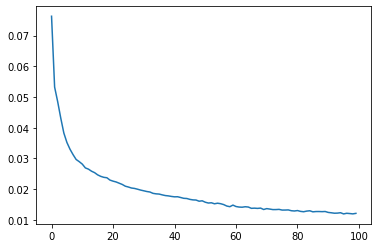

In [110]:
plt.plot(Loss)
plt.show()

In [111]:
path = "/Users/bakshiguptad/ML/MLBasedCaloClusteringPipeLine/siamese_net.pth"
torch.save(siamese_net, path)

## Analysis of test Data before training in 16D space

In [287]:
input_size = 8
path = "/Users/bakshiguptad/ML/MLBasedCaloClusteringPipeLine/siamese_net.pth"
model = SiameseNetwork(input_size)
#model.load(torch.load(path))
model = torch.load(path)

In [288]:
dist = []
label = []
for batch in testDataloader:
        inputs, target = batch
        input1, input2 = inputs

        # Forward pass
        #output1, output2 = siamese_net(input1, input2)
        output1, output2 = model(input1, input2)
        distances = torch.pairwise_distance(output1, output2)
        dist.append(distances)
        label.append(target)

/var/folders/k8/cklb1sxj1p35mft4gbkymsc091k_dc/T/ipykernel_67354/98518432.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(self.labels[index], dtype=torch.float32)


In [289]:
len(dist)

1

In [290]:
distArray = dist[0].detach().numpy()

In [291]:
labelArray = label[0].detach().numpy()

In [292]:
simCells = [i for i in range(len(labelArray)) if labelArray[i]==1]
asimCells = [i for i in range(len(labelArray)) if labelArray[i]==-1]

In [293]:
#asimCells

In [294]:
simArray = distArray[simCells]
asimArray = distArray[asimCells]

In [295]:
asimArray[105591]

3.0386622

In [296]:
# asimilar pair
asimTestCells = total_indices_test[asimCells]

In [297]:
len(asimArray)

150508

In [298]:
len(asimTestCells)

150508

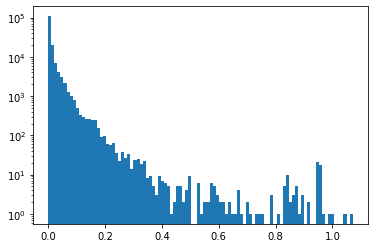

In [299]:
plt.hist(simArray, bins=100)
plt.yscale("log")
#plt.xlim(0,0.1)
plt.show()

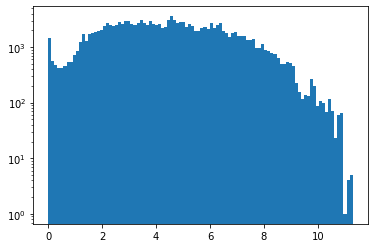

In [300]:
plt.hist(asimArray, bins=100)
plt.yscale("log")
plt.show()

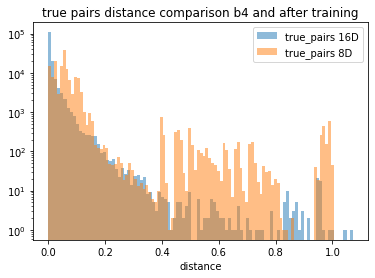

In [301]:
plt.hist(simArray,  
         alpha=0.5, # the transaparency parameter 
         label='true_pairs 16D',bins=100) 
  
plt.hist(simArray_b4, 
         alpha=0.5, 
         label='true_pairs 8D',bins=100) 
  
plt.legend(loc='upper right') 
plt.yscale("log")
plt.xlabel("distance")
plt.title('true pairs distance comparison b4 and after training') 
plt.show()

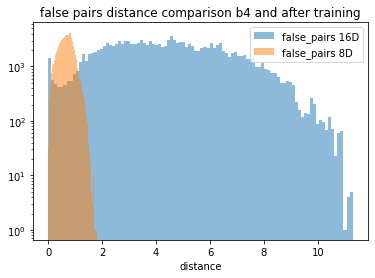

In [302]:
plt.hist(asimArray,  
         alpha=0.5, # the transaparency parameter 
         label='false_pairs 16D',bins=100) 
  
plt.hist(asimArray_b4, 
         alpha=0.5, 
         label='false_pairs 8D',bins=100) 
  
plt.legend(loc='upper right') 
plt.yscale("log")
plt.xlabel("distance")
plt.title('false pairs distance comparison b4 and after training') 
plt.show()

In [303]:
asimArray_sorted = asimArray[asym_sort_index_b4]
simArray_sorted = simArray[sym_sort_index_b4]

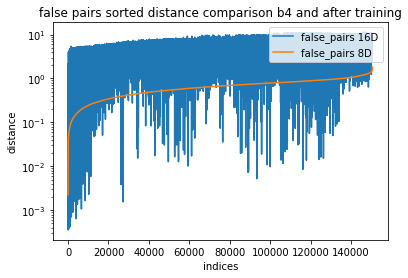

In [304]:
plt.plot(asimArray_sorted,  
         #alpha=0.5, # the transaparency parameter 
         label='false_pairs 16D') 
  
plt.plot(asimArray_b4_sorted, 
         #alpha=0.5, 
         label='false_pairs 8D') 
  
plt.legend(loc='upper right') 
plt.yscale("log")
plt.ylabel("distance")
plt.xlabel("indices")
plt.title('false pairs sorted distance comparison b4 and after training') 
plt.show()

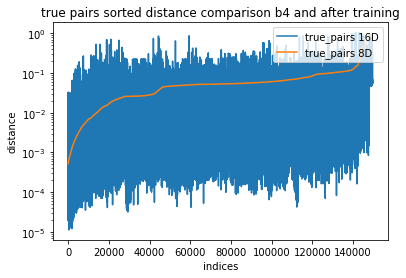

In [305]:
plt.plot(simArray_sorted,  
         #alpha=0.5, # the transaparency parameter 
         label='true_pairs 16D') 
  
plt.plot(simArray_b4_sorted, 
         #alpha=0.5, 
         label='true_pairs 8D') 
  
plt.legend(loc='upper right') 
plt.yscale("log")
plt.ylabel("distance")
plt.xlabel("indices")
plt.title('true pairs sorted distance comparison b4 and after training') 
plt.show()

In [306]:
dist_ev1 = []
label_ev1 = []
for batch in ev1Dataloader:
        inputs, target = batch
        input1, input2 = inputs

        # Forward pass
        output1, output2 = model(input1, input2)
        distances = torch.pairwise_distance(output1, output2)
        dist_ev1.append(distances)
        label_ev1.append(target)

/var/folders/k8/cklb1sxj1p35mft4gbkymsc091k_dc/T/ipykernel_67354/98518432.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(self.labels[index], dtype=torch.float32)


In [307]:
distArray_ev1 = dist_ev1[0].detach().numpy()
labelArray_ev1 = label_ev1[0].detach().numpy()

In [308]:
simCells_ev1 = [i for i in range(len(labelArray_ev1)) if labelArray_ev1[i]==1]
asimCells_ev1 = [i for i in range(len(labelArray_ev1)) if labelArray_ev1[i]==-1]

In [309]:
simArray_ev1 = distArray_ev1[simCells_ev1]
asimArray_ev1 = distArray_ev1[asimCells_ev1]

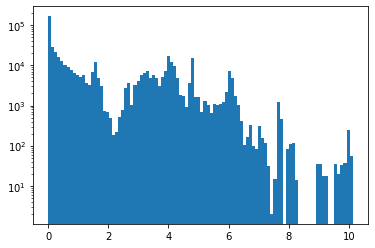

In [310]:
plt.hist(simArray_ev1, bins=100)
plt.yscale("log")
#plt.xlim(0,0.1)
plt.show()

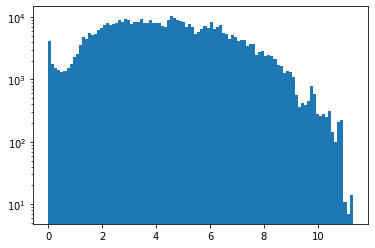

In [311]:
plt.hist(asimArray_ev1, bins=100)
plt.yscale("log")
#plt.xlim(0,0.1)
plt.show()

In [205]:
cellFeatures.shape

(187652, 8)

In [206]:
cellFeatures_3D = cellFeatures[:,:3]

In [207]:
cellFeatures_3D.shape

(187652, 3)

In [208]:
pair_features_test_3D =[]
for pair in total_indices_test:
    pair_features_test_3D.append((cellFeatures_3D[pair[0]],\
                          cellFeatures_3D[pair[1]]))

In [209]:
len(pair_features_test_3D)

300000

In [210]:
pair_3D_dist =[]
for pair in total_indices_test:
    first = cellFeatures_3D[pair[0]]
    second = cellFeatures_3D[pair[1]]
    dist = np.linalg.norm(first - second)/1000
    pair_3D_dist.append(dist)

In [212]:
pair_3D_dist = np.array(pair_3D_dist)

In [213]:
simArray_3D = pair_3D_dist[simCells_b4]
asimArray_3D = pair_3D_dist[asimCells_b4]

In [214]:
sym_sort_index_3D = sorted(range(len(simArray_3D)), key=lambda k: simArray_3D[k])
asym_sort_index_3D = sorted(range(len(asimArray_3D)), key=lambda k: asimArray_3D[k])

In [219]:
simArray_sorted_3D = simArray_3D[sym_sort_index_3D]
asymArray_sorted_3D = asimArray_3D[asym_sort_index_3D]

In [221]:
simArray_sorted_3D

array([0.00421253, 0.00421253, 0.00421253, ..., 3.48467988, 3.55122784,
       3.60876206])

In [226]:
asimArray_sorted_16D = asimArray[asym_sort_index_3D]
simArray_sorted_16D= simArray[sym_sort_index_3D]
simArray_b4_sorted_8D = simArray_b4[sym_sort_index_3D]
asimArray_b4_sorted_8D = asimArray_b4[asym_sort_index_3D]

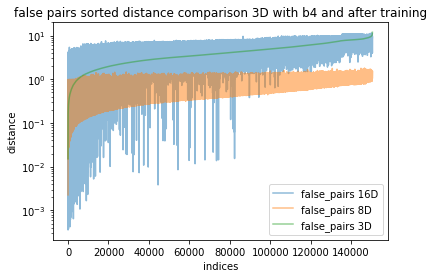

In [228]:
plt.plot(asimArray_sorted_16D,  
         alpha=0.5, # the transaparency parameter 
         label='false_pairs 16D') 
  
plt.plot(asimArray_b4_sorted_8D, 
         alpha=0.5, 
         label='false_pairs 8D') 

plt.plot(asymArray_sorted_3D, 
         alpha=0.5, 
         label='false_pairs 3D') 
  
plt.legend(loc='lower right') 
plt.yscale("log")
plt.ylabel("distance")
plt.xlabel("indices")
plt.title('false pairs sorted distance comparison 3D with b4 and after training') 
plt.show()

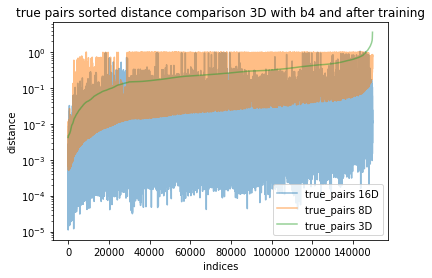

In [231]:
plt.plot(simArray_sorted_16D,  
         alpha=0.5, # the transaparency parameter 
         label='true_pairs 16D') 
  
plt.plot(simArray_b4_sorted_8D, 
         alpha=0.5, 
         label='true_pairs 8D') 

plt.plot(simArray_sorted_3D, 
         alpha=0.5, 
         label='true_pairs 3D') 
  
plt.legend(loc='lower right') 
plt.yscale("log")
plt.ylabel("distance")
plt.xlabel("indices")
plt.title('true pairs sorted distance comparison 3D with b4 and after training') 
plt.show()